<a href="https://colab.research.google.com/github/dustinhodges/DS-Unit-2-Linear-Models/blob/master/213_Hodges_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [37]:
df = df[(df['SALE_PRICE'] > 100000) & 
        (df['SALE_PRICE'] < 2000000) & 
        (df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]

df.shape

(3151, 21)

In [38]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019


Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [39]:
df['SALE_DATE'].dtype

dtype('O')

In [0]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('04/01/2019')
train = df[df.SALE_DATE < cutoff]
test = df[df.SALE_DATE >= cutoff]

Do one-hot encoding of categorical features.

In [41]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,7,OTHER,2360,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
ADDRESS,2507,2497,130-52 LEFFERTS BOULEVARD,2,NaT,NaT


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_AT_PRESENT', 'SALE_DATE', 'LAND_SQUARE_FEET', 'ADDRESS']
moot = ['BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER', 'EASE-MENT']
features = train.columns.drop([target] + high_cardinality + moot)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [43]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,1,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,OTHER,1,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,OTHER,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,3,OTHER,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,3,OTHER,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [45]:
X_train.shape

(2507, 34)

Do feature selection with `SelectKBest`.


In [46]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=12)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2507, 12), (644, 12))

In [47]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_OF_SALE_A2
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).



In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fit a ridge regression model with multiple features.


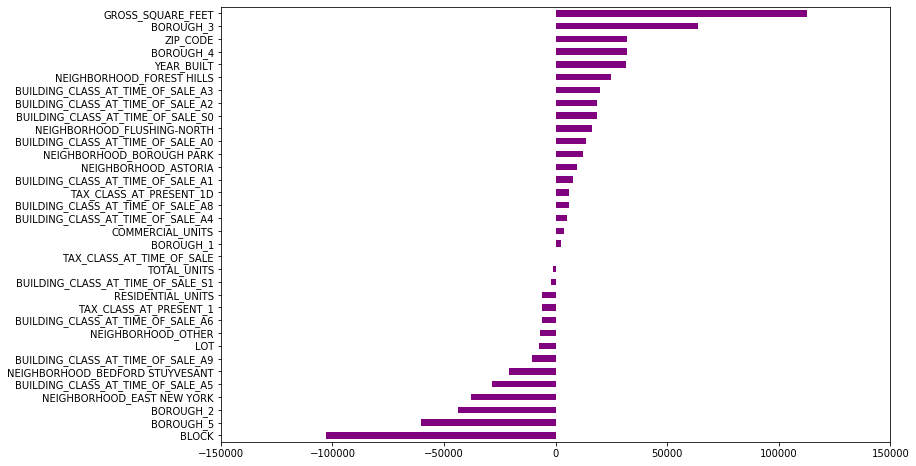

In [61]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

for alpha in [10**2]:

  display(HTML(f'Ridge Regression, with alpha={alpha}'))
  model = Ridge(alpha=alpha)
  model.fit(X_train_scaled, y_train)

  y_pred = model.predict(X_train_scaled)
  mae = mean_absolute_error(y_train, y_pred)
  display(HTML(f'Train MAE: ${mae:,.0f}'))

  y_pred = model.predict(X_test_scaled)
  mae = mean_absolute_error(y_test, y_pred)
  display(HTML(f'Test MAE: ${mae:,.0f}')) 

  coefficients = pd.Series(model.coef_, X_train.columns)
  plt.figure(figsize=(12,8))
  coefficients.sort_values().plot.barh(color='purple')
  plt.xlim(-150000,150000)
  plt.show()

Get mean absolute error for the test set: 
MAE in test set is $157,321